In [99]:
import pandas as pd
import matplotlib.pyplot as plt
#file_name = "test_out/default_post_01_001.csv"
#file_name = "keep_csv/bullet_nopost_02_0025.csv"

#file_name = "test_out/simple_all.csv"
#file_name = "keep_csv/train_all.csv"
#file_name = "keep_csv/panda_adim1.csv"
#file_name = "keep_csv/box2d_all.csv"

dfbu = pd.read_csv("keep_csv/box2d_all.csv")[['post', 'config.algo', 'config.env_name', 'ureward_mean', 'ureward_std', 'mdim_mean', 'cdim_mean', 'mdim_nan_mean', 'mdim_std', 'nreward_mean', 'nreward_std', 'len_mean',
                             'cdim_nan_mean']]#, 'config.post']]

dfb2 = pd.read_csv("keep_csv/train_all.csv")[['post', 'config.algo', 'config.env_name', 'ureward_mean', 'ureward_std', 'mdim_mean', 'cdim_mean', 'mdim_nan_mean', 'mdim_std', 'nreward_mean', 'nreward_std', 'len_mean',
                             'cdim_nan_mean']]#, 'conf

df = pd.concat([dfbu, dfb2])

In [308]:
df2 = pd.DataFrame()
env_disp_name = "Environment"
algo_disp_name = "Algorithm"
o_disp_name = "Reward Baseline"
a_disp_name = "Reward W/ Training"

df2[env_disp_name] = df[df['post'] == 'iden']['config.env_name']
df2[algo_disp_name] = df[df['post'] == 'iden']['config.algo']
df2['brew_mean'] = df[df['post'] == 'iden']['ureward_mean']
df2['brew_std'] = df[df['post'] == 'iden']['ureward_std']
df2['arew_mean'] = df[df['post'] == 'postprocess_default']['ureward_mean'].to_numpy()
df2['arew_std'] = df[df['post'] == 'postprocess_default']['ureward_std'].to_numpy()

df2 = df2.round({'brew_mean':2,'brew_std':1,'arew_mean':2, "arew_std":1})
df2['brew_mean'] = df2['brew_mean'].astype(int)
df2['brew_mean'] = df2[['brew_mean', 'brew_std']].astype(str).agg(' ± '.join, axis=1) 
df2.drop('brew_std', axis=1, inplace=True)
df2['arew_mean'] = df2['arew_mean'].astype(int)
df2['arew_mean'] = df2[['arew_mean', 'arew_std']].astype(str).agg(' ± '.join, axis=1) 

df2.drop('arew_std', axis=1, inplace=True)
df2 = df2.rename({'brew_mean':'Baseline Return'}, axis=1)
df2 = df2.rename({'arew_mean':'Refined  Return'}, axis=1)

for env in df2['Environment']:
    env_dict[env] = 1 

df2 = df2.set_index(["Algorithm", "Environment"]).sort_index()
envs = list(env_dict.keys())

index_list = []
for algo in ["a2c","ppo","ddpg","td3","sac","tqc"]:
    for env in envs:
        index_list.append((algo,env))
        
df2 = df2.reindex(index_list)# ("ppo", envs), ("ddpg", envs), ("td3",envs), ("td3", envs) ,("tqc", envs)])
df2 = df2.reset_index()

#index = pd.MultiIndex.from_frame(df2)
#df2.set_index(["Algorithm","Environment"])
#df2.set_index(index).drop(["Environment", "Algorithm"],axis=1)

In [311]:
for env in env_dict.keys():
    dfp = df2[df2['Environment'] == env].drop(["Algorithm", "Environment"],axis=1,inplace=False).transpose()
    
    #dfp["Environment"] = env
    #dfp.set_index("Environment",inplace=True) 
    #dfp.drop("Environment",axis=0)
    #display(dfp)
    print(env)
    print(dfp.to_latex(multirow=True, header=False))

LunarLanderContinuous-v2
\begin{tabular}{lllllll}
\toprule
Baseline Return &  96 ± 148.3 &  277 ± 23.0 &   247 ± 92.5 &  199 ± 99.4 &  226 ± 103.5 &  280 ± 23.0 \\
Refined  Return &  208 ± 88.6 &  270 ± 22.3 &  217 ± 149.3 &  259 ± 21.7 &   279 ± 14.0 &  288 ± 17.7 \\
\bottomrule
\end{tabular}

BipedalWalker-v3
\begin{tabular}{lllllll}
\toprule
Baseline Return &  301 ± 1.0 &  207 ± 98.4 &  199 ± 140.0 &  318 ± 2.4 &  261 ± 116.9 &  292 ± 125.1 \\
Refined  Return &  313 ± 1.1 &   325 ± 1.0 &    291 ± 1.5 &  334 ± 0.6 &    321 ± 1.2 &    344 ± 0.2 \\
\bottomrule
\end{tabular}

BipedalWalkerHardcore-v3
\begin{tabular}{lllllll}
\toprule
Baseline Return &   78 ± 109.5 &  131 ± 123.3 &  NaN &  -94 ± 12.7 &  -34 ± 88.8 &  224 ± 101.7 \\
Refined  Return &  145 ± 100.9 &   131 ± 98.6 &  NaN &   -24 ± 5.3 &   18 ± 69.9 &  243 ± 100.1 \\
\bottomrule
\end{tabular}

Pendulum-v0
\begin{tabular}{lllllll}
\toprule
Baseline Return &  -230 ± 99.2 &  -171 ± 127.4 &  -157 ± 99.3 &  -110 ± 83.5 &  -116 ± 1

In [1]:
# Hack for visualizing, can only load one environment / process with rendering. Need to restart NB to change the env
model_dir = "./keep_agents/train_all"

import os
from seagul.zoo3_utils import load_zoo_agent, ALGOS, do_rollout_stable
import pybullet_envs
import gym

viz_env = "Walker2DBulletEnv-v0"
viz_algo = "ddpg"
model_dict = {}
env_dict = {}

for algo_file in os.scandir(model_dir):
    algo_dir = algo_file.path
    algo = algo_dir.split("/")[-1]
    if algo == viz_algo:
        model_dict[algo] = {}
        env_dict[algo] = {}
        for env_file in os.scandir(algo_dir):
            env_dir = env_file.path
            env_name = env_dir.split("/")[-1]
            model_dict[algo][env_name] = {}
            env_dict[algo][env_name] = {}
            if viz_env in env_name:

                env, original_model = load_zoo_agent(env_name, algo, render=False, env_kwargs={"render":True})
                env.close()
                env_dict[algo][env_name] = env
                model_dict[algo][env_name]['original'] = original_model
                for pkl_file in os.scandir(env_dir):
                    post_name = pkl_file.path.split("/")[-1].split(".")[0]
                    model_dict[algo][env_name][post_name] = ALGOS[algo].load(pkl_file.path, env=env, device='cpu')

/home/sgillen/work/external/rl-baselines3-zoo/rl-trained-agents/ddpg/Walker2DBulletEnv-v0_1/Walker2DBulletEnv-v0


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
#env = env.envs[0]
env.reset()

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.        ,  0.9693574 ,  0.        ,
         1.0212944 ,  0.        ,  0.02165215,  0.        ,  1.0076593 ,
         0.        ,  1.0478605 ,  0.        ,  0.08277022,  0.        ,
         0.        ,  0.        ,  1.        ]], dtype=float32)

In [6]:
model = model_dict[viz_algo][viz_env]['original']
#env = gym.make(viz_env, render=True)
o,a,r,i = do_rollout_stable(env, model, render_wait=0.002, render=True, return_on_done=False, override_reset=False, num_steps=10000)
print(len(r))
print(i)

KeyboardInterrupt: 

(1000.0, 4000.0)

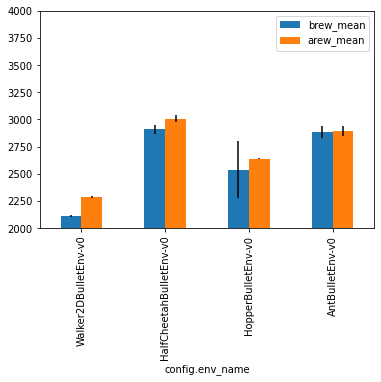

<Figure size 432x288 with 0 Axes>

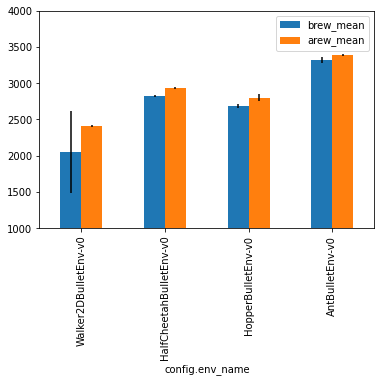

<Figure size 432x288 with 0 Axes>

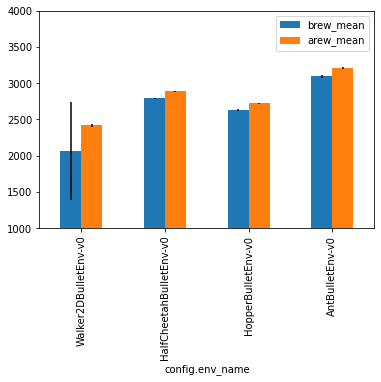

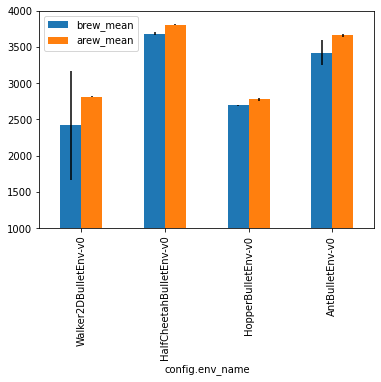

In [6]:
dfp = df2[df2['config.algo'] == 'ppo']
dfp.plot.bar(x='config.env_name', y=['brew_mean', 'arew_mean'], yerr={'brew_mean':dfp['brew_std'], 'arew_mean':dfp['arew_std']})
plt.ylim(2000, 4000)

plt.figure()

dfp = df2[df2['config.algo'] == 'td3']
dfp.plot.bar(x='config.env_name', y=['brew_mean', 'arew_mean'], yerr={'brew_mean':dfp['brew_std'], 'arew_mean':dfp['arew_std']})
plt.ylim(1000, 4000)

plt.figure()


dfp = df2[df2['config.algo'] == 'sac']
dfp.plot.bar(x='config.env_name', y=['brew_mean', 'arew_mean'], yerr={'brew_mean':dfp['brew_std'], 'arew_mean':dfp['arew_std']})
plt.ylim(1000, 4000)



dfp = df2[df2['config.algo'] == 'tqc']
dfp.plot.bar(x='config.env_name', y=['brew_mean', 'arew_mean'], yerr={'brew_mean':dfp['brew_std'], 'arew_mean':dfp['arew_std']})
plt.ylim(1000, 4000)

In [11]:
algo='tqc'
df[(df['post'] == 'iden')]# & (df['config.algo'] == algo) ]

,post,config.algo,config.env_name,ureward_mean,ureward_std,mdim_mean,cdim_mean,mdim_nan_mean,mdim_std,nreward_mean,nreward_std,len_mean,cdim_nan_mean
0,iden,ppo,Walker2DBulletEnv-v0,2111.364508,10.776165,1.560541,5.336190,1.560541,0.145203,33.376486,0.170349,1000.0,5.336190
1,iden,td3,Walker2DBulletEnv-v0,2052.887746,568.973756,1.296572,10.881104,1.296572,0.192960,2052.887692,568.973735,917.5,10.881104
2,iden,sac,Walker2DBulletEnv-v0,2064.071153,681.336737,1.267627,10.661319,1.267627,0.276100,2064.071131,681.336729,901.5,10.661319
3,iden,tqc,Walker2DBulletEnv-v0,2418.166841,755.757666,1.305009,9.415485,1.305009,0.128889,2418.166795,755.757647,907.8,9.415485
4,iden,ppo,HalfCheetahBulletEnv-v0,2908.169612,38.828683,1.573944,5.134705,1.573944,0.093851,26.925796,0.359502,1000.0,5.134705
5,iden,td3,HalfCheetahBulletEnv-v0,2826.124755,14.489177,1.374065,8.956402,1.374065,0.082803,2826.124731,14.489161,1000.0,8.956402
6,iden,sac,HalfCheetahBulletEnv-v0,2793.418870,8.802347,1.159261,8.502494,1.159261,0.097310,2793.418774,8.802360,1000.0,8.502494
7,iden,tqc,HalfCheetahBulletEnv-v0,3683.604083,17.602738,1.454502,5.840621,1.454502,0.065291,3683.604077,17.602688,1000.0,5.840621
8,iden,ppo,HopperBulletEnv-v0,2537.098882,263.534898,1.433970,4.877648,1.433970,0.085089,29.168804,3.029838,966.4,4.877648
9,iden,td3,HopperBulletEnv-v0,2679.315193,28.479300,1.240117,6.282698,1.240117,0.086367,2679.315210,28.479283,998.0,6.282698


In [64]:
df[(df['post'] == 'postprocess_default') & (df['config.algo'] == algo) ]

,post,config.algo,config.env_name,ureward_mean,ureward_std,mdim_mean,cdim_mean,mdim_nan_mean,mdim_std,nreward_mean,nreward_std,len_mean,cdim_nan_mean
21,postprocess_default,td3,Walker2DBulletEnv-v0,2449.883711,9.399407,1.249671,11.916661,1.249671,0.087513,2449.883789,9.399403,1000.0,11.916661
25,postprocess_default,td3,HalfCheetahBulletEnv-v0,2954.047030,12.790530,1.151075,9.411630,1.151075,0.108290,2954.047046,12.790509,1000.0,9.411630
29,postprocess_default,td3,HopperBulletEnv-v0,2849.498259,11.254691,1.303436,7.082571,1.303436,0.049567,2849.498267,11.254670,998.6,7.082571
33,postprocess_default,td3,AntBulletEnv-v0,3443.013020,15.873944,1.523520,8.559933,1.523520,0.119517,3443.012988,15.873920,1000.0,8.559933
37,postprocess_default,td3,ReacherBulletEnv-v0,12.393237,5.586584,0.623266,4.359015,0.623266,0.080227,12.393237,5.586585,150.0,4.359015
